In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

sns.set(style='ticks', context='talk', color_codes=True)
%matplotlib inline

In [2]:
df = pd.read_excel('default of credit card clients.xls', skiprows=[1])

In [3]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

Split data into train and test datasets.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=13)

## Random forests

In [5]:
rf = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=123)
rf.fit(X_train, y_train)
print('Training accuracy: ', rf.score(X_train, y_train), '\nTest accuracy: ', rf.score(X_test, y_test))

Training accuracy:  0.999291666667 
Test accuracy:  0.807333333333


There is a huge gap between training and test accuracy. This is a sign of overfitting. It can also be observed in the following learning curve.

(0.8, 1.0)

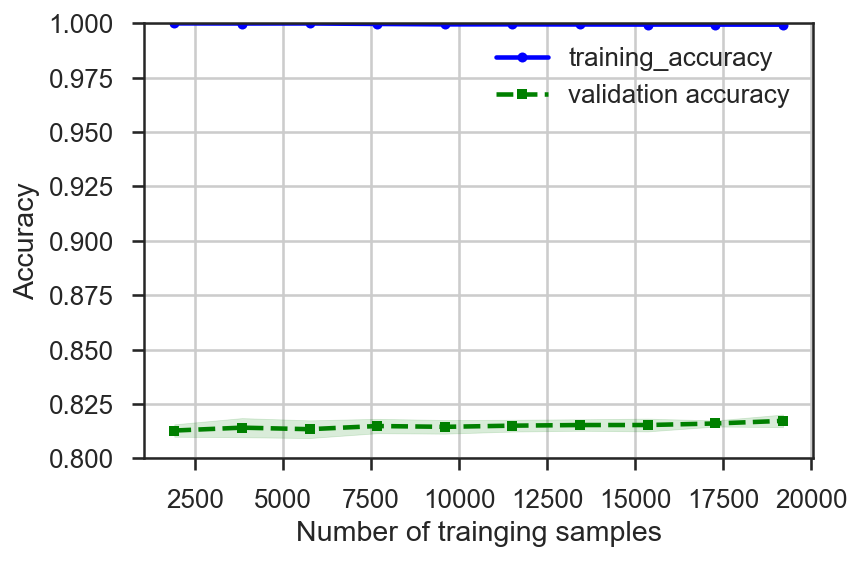

In [6]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(estimator=rf, X=X_train, y=y_train,
                                                       train_sizes=np.linspace(0.1, 1, 10),
                                                       cv=5, n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training_accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, color='blue', alpha=0.15)
plt.plot(train_sizes, test_mean, color='green', marker='s', markersize=5, linestyle='--', label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, color='green', alpha=0.15)
plt.grid()
plt.xlabel('Number of trainging samples')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0.8, 1.0])

Training accuracy remains extremely high while test accuracy is much worse. This means the model is too flexible. Thus the flexibility must be controlled via hyperparameter tuning.

In [7]:
params = {'criterion': ['gini', 'entropy'], 'max_depth': [8, 10, None],
          'min_samples_leaf': [2, 3, 4], 'min_samples_split': [2,3,4]}
rf_grid = GridSearchCV(rf, params, n_jobs=-1)

In [8]:
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=False, random_state=123, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [8, 10, None], 'min_samples_leaf': [2, 3, 4], 'min_samples_split': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [9]:
rf_grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [10]:
print('Training accuracy: ', rf_grid.score(X_train, y_train), '\nTest accuracy: ', rf_grid.score(X_test, y_test))

Training accuracy:  0.833958333333 
Test accuracy:  0.8145


## Logistic regression with elastic net regularization

In [11]:
scl = StandardScaler()
sgd = SGDClassifier(loss="log", penalty="elasticnet", alpha=0.001,l1_ratio=0.9, max_iter=1000, n_jobs=-1)
sgd_pipe =  Pipeline([('scl', scl), ('sgd', sgd)])

In [12]:
sgd_pipe.fit(X_train, y_train)
print('Training accuracy: ', sgd_pipe.score(X_train, y_train), '\nTest accuracy: ', sgd_pipe.score(X_test, y_test))

Training accuracy:  0.811791666667 
Test accuracy:  0.804166666667


### Hyperparameter tuning

In [13]:
sgd_params = {'sgd__alpha': [10**c for c in range(-4, 2)], 
              'sgd__l1_ratio': [0.5, 0.8, 0.9, 0.95, 0.99, 1]}
sgd_grid = GridSearchCV(sgd_pipe, sgd_params, n_jobs=-1)

In [14]:
sgd_grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sgd', SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.9, learning_rate='optimal',
       loss='log', max_iter=1000, n_iter=None, n_jobs=-1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       tol=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'sgd__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10], 'sgd__l1_ratio': [0.5, 0.8, 0.9, 0.95, 0.99, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [15]:
sgd_grid.best_estimator_

Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sgd', SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=1, learning_rate='optimal',
       loss='log', max_iter=1000, n_iter=None, n_jobs=-1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       tol=None, verbose=0, warm_start=False))])

In [16]:
print('Training accuracy: ', sgd_grid.score(X_train, y_train), '\nTest accuracy: ', sgd_grid.score(X_test, y_test))

Training accuracy:  0.812416666667 
Test accuracy:  0.805833333333


## Logistic regression

In [17]:
lr = LogisticRegression(random_state=123)
lr_pipe = Pipeline([('scl', scl), ('lr', lr)])
lr_pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=123, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [18]:
print('Traing accuracy: ', lr_pipe.score(X_train, y_train), 'Test accuracy: ', lr_pipe.score(X_test, y_test))

Traing accuracy:  0.812416666667 Test accuracy:  0.805333333333


### Hyparameter tuning

In [19]:
lr_params = {'lr__C': [10**c for c in range(-4, 4)]}
lr_grid = GridSearchCV(lr_pipe, lr_params)
lr_grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=123, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'lr__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [20]:
lr_grid.best_estimator_

Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lr', LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=123, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [21]:
print('Traingin accuracy: ', lr_grid.score(X_train, y_train), 'Test accuracy: ', lr_grid.score(X_test, y_test))

Traingin accuracy:  0.812416666667 Test accuracy:  0.805333333333


## Boosting trees

In [22]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4), n_estimators=20, random_state=123, learning_rate=0.1)

In [23]:
ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.1, n_estimators=20, random_state=123)

In [24]:
print('Training accuracy: ', ada.score(X_train, y_train), 'Test accuracy: ', ada.score(X_test, y_test))

Training accuracy:  0.826083333333 Test accuracy:  0.817


## LightGBM

In [25]:
lgb = LGBMClassifier(learning_rate=0.02, max_depth=6, n_estimators=100, n_jobs=-1, random_state=11, num_leaves=18)

In [26]:
lgb.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', colsample_bytree=1.0, learning_rate=0.02,
        max_bin=255, max_depth=6, min_child_samples=10, min_child_weight=5,
        min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=18,
        objective=None, random_state=11, reg_alpha=0.0, reg_lambda=0.0,
        silent=True, subsample=1.0, subsample_for_bin=50000,
        subsample_freq=1)

In [27]:
print('Training accuracy: ', lgb.score(X_train, y_train), 'Test accuracy: ', lgb.score(X_test, y_test))

Training accuracy:  0.826375 Test accuracy:  0.817666666667


## XGBoost

In [28]:
xgb = XGBClassifier(seed = 0, learning_rate=0.01, max_depth=4, n_estimators=60, n_jobs=-1, random_state=11)

In [29]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=60,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=11, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=0, silent=True, subsample=1)

In [30]:
print('Training accuracy: ', xgb.score(X_train, y_train), 'Test accuracy: ', xgb.score(X_test, y_test))

Training accuracy:  0.826125 Test accuracy:  0.8175


Text(0,0.5,'True Positive Rate')

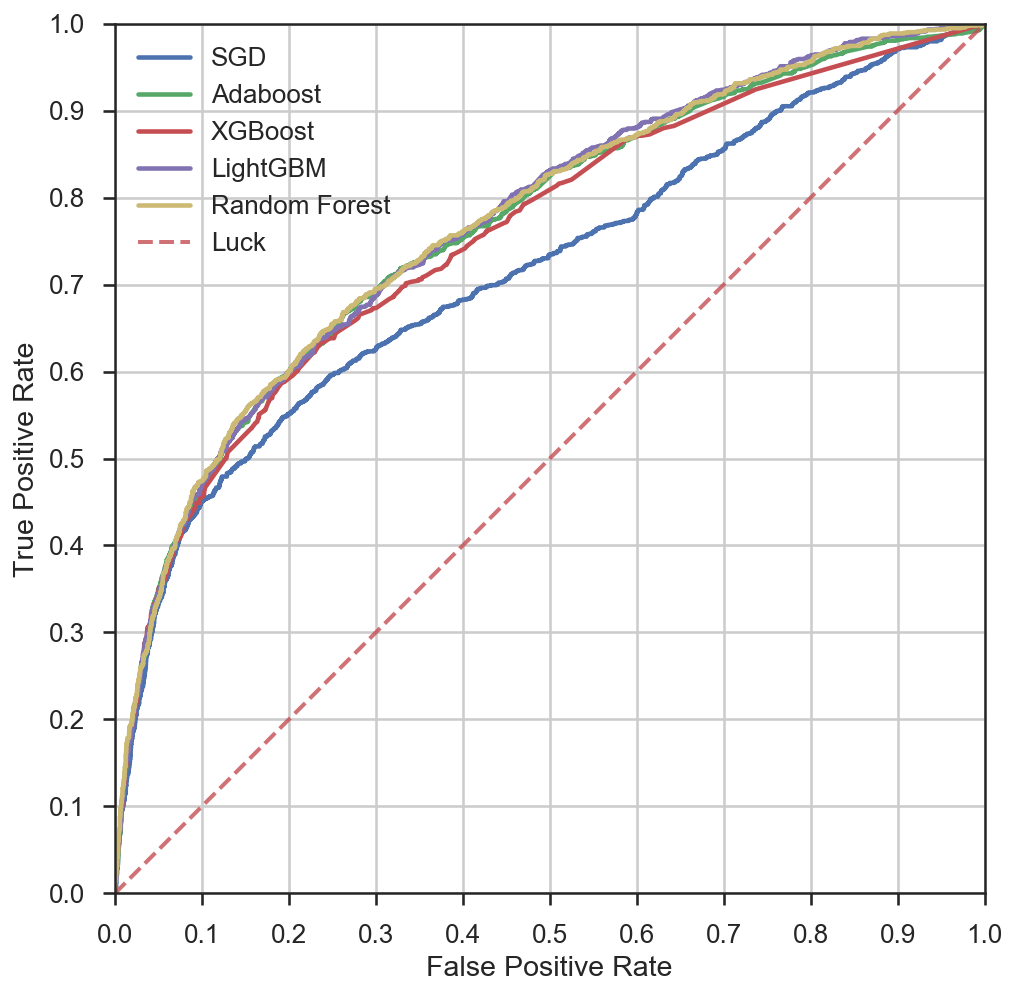

In [31]:
# plot the roc curve
from sklearn.metrics import roc_curve, auc
y_score = sgd_grid.predict_proba(X_test)[:, 1]
y_score2 = ada.predict_proba(X_test)[:, 1]
y_score3 = xgb.predict_proba(X_test)[:, 1]
y_score4 = lgb.predict_proba(X_test)[:, 1]
y_score5 = rf_grid.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_score2, pos_label=1)
fpr3, tpr3, thresholds3 = roc_curve(y_test, y_score3, pos_label=1)
fpr4, tpr4, thresholds4 = roc_curve(y_test, y_score4, pos_label=1)
fpr5, tpr5, thresholds5 = roc_curve(y_test, y_score5)
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label='SGD')
plt.plot(fpr2, tpr2, label='Adaboost')
plt.plot(fpr3, tpr3, label='XGBoost')
plt.plot(fpr4, tpr4, label='LightGBM')
plt.plot(fpr5, tpr5, label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)
plt.xlim([0,1])
plt.ylim([0,1])
plt.xticks(np.arange(0,1.1,0.1))
plt.yticks(np.arange(0,1.1,0.1))
plt.grid()
plt.gca().set_aspect('equal')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

The figure shows that random forest, adaboost and lightgbm have very similar performance. They perform better than xgboost and logistic regression with elastic net regularization.

## Majority voting

In [32]:
ens = VotingClassifier(estimators=[('rf', rf_grid.best_estimator_), ('xgb', xgb), ('lgb', lgb)],
                        voting='soft', n_jobs=-1)

In [33]:
ens.fit(X_train, y_train)
print('Training accuracy: ', ens.score(X_train, y_train), 'Test accuracy: ', ens.score(X_test, y_test))

Training accuracy:  0.828 Test accuracy:  0.817


In this case majority voting does not improve classification accuracy.